### Task A3 Machine Learning for binary classification using Logistic Regression

Here you will start by running some code provided to you which will create a dataset. You will use this to train a Logistic Regression classification model. 

The dataset consists of a set of points $(x_0, x_1)$ in the plane each of which is either blue or red. Your model will take as input the coordinates of a point in the plane and return 0 if the point is likely to be red, or 1 if the point is likely to be blue. In practice your model will output a float (real number) between 0 and 1 which is the probability for the point to be blue, and you will then use 0.5 as a threshold to predict the point as being blue or red.

**You are guided through this task below. You will see code cells that you need to run and code cells that you need to edit/complete. You can also add new code/markdown cells as required. You may wish to add markdown cells to comment on your code or to comment on any outputs you see.**

#### Create and visualise the dataset

**Run the cell below to create a planar dataset.** A visualisation of this is provided, you will see that it looks like a flower with some red points and some blue points.

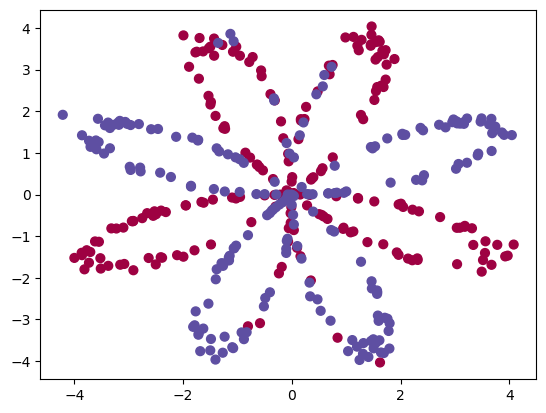

In [1]:
# Create the flower dataset

import numpy as np
import matplotlib.pyplot as plt
import copy

def load_flower_dataset():
    np.random.seed(1)

    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality

    X = np.zeros((m,D)) # data matrix where each row is a single example
    y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    X = X.T
    y = y.T

    return X, y

# Load the dataset:
X, y = load_flower_dataset()

# Visualize the dataset:
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral);

You will see that you have some red points (which have label $y=0$) and some blue points (which have label $y=1$).

More precisely you have created two vectors `X` and `y` (shorthands for $X_{\text{train}}$ and $y_{\text{train}}$) containing 400 training examples:
- The numpy-array `X` of dimensions (2, 400), every column of `X` is the feature vector for a single training example and contains the coordinates of the point: $\begin{pmatrix} x_0 \\ x_1\end{pmatrix}$.
- The numpy-array `y` of dimensions (1,400), every column of `y` contains the label for a single training example (0 for red, 1 for blue). 
- The columns of `X` correspond to the columns of `y`, i.e. the point in the first column of `X` corresponds to the first entry in `y` and so on.

Your goal is to build a model to fit this data. In other words, you want the model to define regions of the plane as either red or blue. Red regions will correspond to points $(x_0,x_1)$ where the model returns a value less than 0.5 and with any other parts of the plane being blue regions.

Let's start by building a logistic regression model and then measuring its performance on this problem. You will build it in numpy from scratch. 

These are the steps to build your model.

1. Define the structure:
$$
\hat y = \sigma\left( W \cdot x+b \right)=\sigma\left(\begin{pmatrix} w_0 & w_1\end{pmatrix}\cdot \begin{pmatrix}x_0 \\ x_1\end{pmatrix}+b\right).
$$
Here the notation is the same as the one in the lecture presentation for this project. In this case, for each example, we take a linear combination $w_0x_0+w_1x_1+b$ of the input features $x_0$ and $x_1$), where $w_0,w_1,b$ are real numbers, followed by a *sigmoid* activation function $\sigma(\lambda)=\displaystyle\frac{1}{1+\exp(-\lambda)}$.  The output $\hat y$ is the model's predicted probability that the point $x=\begin{pmatrix}x_0 \\ x_1\end{pmatrix}$ is blue. Here $W = \begin{pmatrix} w_0 & w_1\end{pmatrix}$ is known as the weight matrix and $b$ is the bias vector (which in this special case will actually be a single value, a $1\times 1$ matrix).

2. Initialize the model's trainable parameters $W$ and $b$.

3. The training loop is then as follows:
    - Implement forward propagation:  compute an array whose entries are $\hat{y}^{(i)}$ for each training example, with the current values of $W$ and $b$. Here $\hat{y}^{(i)}$ is the output probability for example in column $i$ of $X$.
    - Compute the cost $J$ for the current values of the parameters.
    - Implement backward propagation to get the gradients, i.e. the rate of change of the $J$ with respect to each of $w_0,w_1$ and $b$ at their current values.
    - Update the parameters using these gradients. This is known as gradient descent.

In practice, you'll build helper functions for each of these steps, and then merge them into one function called `model()`. Once you've built `model()` and used it to optimise the parameters, you can make predictions on new data.

#### Initialize parameters

**Complete the function `initialize_parameters` started below.** It takes in the dimension of the input layer `n_X` and the dimension of the output layer `n_y` and returns returns a Python dictionary `parameters`. The dictionary `parameters` contains the initialized parameters of the model: the weight matrix `W` and the bias vector `b`.

Note that `n_X = 2` in our example, each point has two input coordinates,  and the dimension of the output layer is `n_y = 1`. This means that `W` will be a $1\times 2$ matrix and `b` will be a $1\times 1$ matrix for our example. However we would like our function to work more generally, and be in a form which can be adapted for use later on in this project, so we'd like the user to be able to specify `n_X` and `n_y` as inputs to `initialize_parameters`.

- Use: `np.random.randn(n,m) * 0.01` to randomly initialize a matrix of the required shape for `W`.
- Initialize the bias vector `b` so that all of its entries are zero.
- Return both of these in a dictionary called `parameters` with names *W* and *b* respectively.

**Once you have completed the code run this cell.**

In [2]:
def initialize_parameters(n_X, n_y):
    """
    Argument:
    n_X -- integer
    n_y -- integer

    Returns:
    parameters -- python dictionary containing your parameters:
                    W -- weight matrix
                    b -- bias vector
    """

    #Initialize weight matrix nd bias vector
    W = np.random.randn(1,n_X)*0.01
    b = np.zeros((1,n_y))

    #Store W and b in a dictionary parameters
    parameters = {"W": W,
                  "b": b}

    return parameters

#### Forward Propagation

Next you will implement forward propagation for logistic regression:

$$
z = WX + b \text{ and then } 
\hat y = \sigma(z)
$$

As above, for $\lambda\in\mathbb{R}$, $\sigma(\lambda)=\displaystyle\frac{1}{1+\exp(-\lambda)}$ (this is applied entry-wise to $z$ in the above). 

**Start by implementing the sigmoid function in numpy by replacing *None* in the code cell below with appropriate code. Then run the cell.**

In [3]:
def sigmoid(z):
    """
    Argument:
    z -- input data, numpy array

    Returns:
    numpy array that contains sigmoid function applied to each
    element of z.
    """
    return 1/(1+np.exp(-z))

**Complete the function `forward_propagation` started below.** It calculates the output of the logistic regression model, called `y_hat`, and returns (as a tuple) `y_hat` and `z` (in the notation given above).

**Once you have completed the code run this cell.**

In [4]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data, numpy array of dimension (2, 400). Every column of X
         is the feature vector for a single training example (input of the logistic regression)
    parameters -- python dictionary containing the values of W and b to be used
                  to compute the forward propagation.

    Returns:
    y_hat -- numpy array of dimension (1,400). Every column of y_hat is the
             output probability of the logistic regression for that training example.
    z -- numpy array of dimension (1,400), result of linear transformation before sigmoid activation is applied.
    """

    # retrieve W and b from the dictionary "parameters"
    W,b = parameters['W'],parameters['b']

    # compute z
    z = np.matmul(W,X) + b

    # Compute y_hat
    y_hat = sigmoid(z)

    return y_hat, z

#### Compute cost

Given the predictions $\hat y^{(i)}$ on all the training examples, you can compute the cost $J$ as the average over all training examples of the losses:
$$
J = \frac{1}{m} \sum\limits_{i = 0}^{m} L(\hat y^{(i)}, y^{(i)})  .
$$
Here we are using the binary cross-entropy loss:
$$
L(\hat y^{(i)}, y^{(i)}) = -\large\left(\small y^{(i)}\log\left(\hat y^{(i)}\right) + (1-y^{(i)})\log\left(1- \hat y^{(i)}\right)  \large  \right).
$$

Recall $y^{(i)}$ is the $i^{\text{th}}$ component in $y$, i.e. the label for example $i$ and $\hat{y}^{(i)}$ is the models current prediction of this label, the $i^{\text{th}}$ component in $\hat{y}$.

**Complete the function `compute_cost()`, started below, to compute the value of the cost $J$:**

1. First compute the vector of losses element-wise using the numpy arrays given as inputs `y_hat` and `y`.

2. Sum the losses and divide by the number of training examples `m`. Call this value `cost`.

3. Cast `cost` as type `float` using `float()` and return it.

**Once you have completed the code run this cell.**

In [5]:
def compute_cost(y_hat, y):
    """
    Arguments:
    y_hat -- numpy array, output of forward propagation
    y -- numpy array of the same shape as y_hat, containing the true labels (0 for red, 1 for blue)

    Returns:
    cost -- a float which is the cross-entropy cost
    """

    # retrieve number of training examples from the shape of y
    m = y.shape[1]

    # compute the vector of losses by computing the cross-entropy loss element-wise
    def L(a,b):
        return -(b*np.log(a)+(1-b)*np.log(1-a))

    # compute the total cost by averaging the loss over all training examples
    J = 0
    for i in range(1,m):
        J += L(y_hat[0,i],y[0,i])
    J /= m

    # cast cost as a float
    cost = float(J)

    return cost

#### Backpropagation

You can now implement backward propagation. Note that you will complete the code cell below this, much of the code is already given to you but you need to stick with the notation established.

NOTATION: in general for a generic numpy array `M` and a function $F$ with the entries of `M` as inputs, denote by `dM` the numpy array representing the gradient of $F$ with respect to `M`. More precisely `dM` contains the partial derivatives of $F$ with respect to the entries of `M`. For example if
$$M = \begin{pmatrix} a_{0,0} & a_{0,1} & a_{0,2} \\ a_{1,0} & a_{1,1} &  a_{1,2}\end{pmatrix}$$ and $F$ is a function of $a_{0,0},a_{0,1},a_{0,2},a_{1,0},a_{1,1},a_{1,2}$ then $$dM = \begin{pmatrix} \frac{\partial F}{\partial a_{0,0}} & \frac{\partial F}{\partial a_{0,1}} & \frac{\partial F}{\partial a_{0,2}} \\ \frac{\partial F}{\partial a_{1,0}} & \frac{\partial F}{\partial a_{1,1}} & \frac{\partial F}{\partial a_{1,2}}\end{pmatrix}.$$

Throught this project $F$ will be the cost function $J$.

**Complete the function `backward_propagation()` started below.** It takes in a dictionary `parameters` containing the current parameters, `y_hat`,`X` and `y` and it returns a dictionary containing the gradients `dW` and `db` of the cost function with respect to the trainable parameters `W` and `b`. 

You are given the key code for calculating `dW` and `db`, it is, in the notation already established.

`dz = y_hat - y
dW = np.dot(dz, X.T)/m
db = np.sum(dz, axis=1, keepdims=True)/m`

You will see these lines of code in the cell below.

**Once you have completed the code run this cell.**


In [6]:
def backward_propagation(parameters, y_hat, X, y):
    """
    Implement the backward propagation.

    Arguments:
    parameters -- python dictionary containing W and b to use
    y_hat - from output of forward prop
    X -- input data
    y -- labels vector

    Returns:
    grads -- python dictionary containing the gradients
    """
    # Retrieve the number of training examples from the shape of y
    m = y.shape[1]

    # retrieve W from the dictionary "parameters".
    W = parameters['W']

    # Backward propagation: calculate dW, and db.
    dz = y_hat - y
    dW = np.dot(dz, X.T)/m
    db = np.sum(dz, axis=1, keepdims=True)/m

    grads = {"dW": dW,
             "db": db}

    return grads

#### Update parameters

Next you will define a function to update parameters using gradient descent. In a similar way to that seen in task A2,

1. $W$ will be updated to

$$W - dW\times \text{learning rate}.$$

and

2. $b$ will be updated to$$b - db\times\text{learning rate}.$$

**Complete the function `update_parameters()` started below.** It takes in the dictionary `parameters` containing the current parameters `W` and `b`, the dictionary `grads` containing the current gradient `dW`,`dB` and the learning rate (which defaults to the value $1.2$). **Once you have completed the code run this cell.**

In [7]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Arguments:
    parameters -- python dictionary containing the parameters
    grads -- python dictionary containing the gradients

    Returns:
    parameters -- python dictionary containing the updated parameters
    """
    # Retrieve a copy of each parameter from the dictionary "parameters". Use copy.deepcopy(...) for W
    
    W = copy.deepcopy(parameters["W"])
    b = copy.deepcopy(parameters['b'])

    # Retrieve each gradient from the dictionary "grads"
    dW,db = grads['dW'],grads['db']

    # Update each parameter
    W -= dW*learning_rate
    b -= db*learning_rate

    # Store the new parameters in the dictionary parameters
    parameters = {"W": W,
                  "b": b}

    return parameters

#### Model

Now you will put everything together into a function `model` where you will apply `update_parameters` iteratively to update the parameters a number of times.

**Complete the function `model` started below.** It takes as inputs the training data `X`, `y`, a positive integer `num_iterations` which is the number of times the parameters will be updated (defaulting to $10,000$) and a boolean `print_cost` which, when set to `True`, will mean the function prints out some costs as the values of the parameters are updated). `model` return a dictionary containing the optimised parameters at the end of this process. **Once you have completed the code run this cell.**

In [8]:
def model(X, y, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- numpy array, input data
    y -- numpy array, true labels
    num_iterations -- number of iterations in the gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations

    Returns:
    parameters -- python dictionary which contains the optimized parameters
                  learnt by the model.
    """
    # Optional: to control the random seed of the initialization uncomment next line:
    np.random.seed(3)

    # retrieve n_X and n_y from X and y
    n_X = X.shape[0]
    n_y = y.shape[0]

    # Initialize parameters
    parameters = initialize_parameters(n_X,n_y)

    # Training loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation
        y_hat,z = forward_propagation(X, parameters)

        # Compute the cost
        cost = compute_cost(y_hat, y)

        # Backpropagation
        grads = backward_propagation(parameters, y_hat, X, y)

        # Update parameters (use learning_rate = 1.2)
        parameters = update_parameters(parameters, grads)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    learned_parameters = parameters
    
    # return learned parameters
    return learned_parameters

#### Predict on new data

Below you are given a complete function `predict` that uses the learned parameters (output of `model`) and the `forward_propagation` function to predict a class for each example in the input matrix `X`. **Run the code cell below.**

In [9]:
def predict(learned_parameters, X):
    """
    Arguments:
    parameters -- python dictionary containing the learned parameters given by model
    X -- numpy array input data

    Returns
    predictions -- vector of predictions for each column of X (red: 0 / blue: 1)
    """

    # Compute predicted probabilities using the learned parameters
    
    y_hat, z = forward_propagation(X, learned_parameters)

    # Classify as 0 or 1 using 0.5 as a threshold
    
    predictions = (y_hat > 0.5)

    return predictions

#### Plot the results and calculate accuracy

You are given the complete function `plot_decision_boundary` below which plots the decision boundary of the trained model along with the original data. It takes as arguments the `learned_parameters` (as output by the `model` function), the model, the training examples `X` and the true labels `y`. **Run the code cell below.**

In [10]:
# Function to plot decision boundary

def plot_decision_boundary(learned_parameters, X, y):

    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = predict(learned_parameters,np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, 10, alpha=0.5,cmap=plt.cm.Spectral)
    plt.ylabel('x1')
    plt.xlabel('x0')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.title("Decision Boundary")
    plt.show()

Now you can train your model using the training examples, and plot the decision boundary for the learned parameters, alongside the orginal data. **Run the code cell below**.

Cost after iteration 0: 0.691990
Cost after iteration 1000: 0.672119
Cost after iteration 2000: 0.672119
Cost after iteration 3000: 0.672119
Cost after iteration 4000: 0.672119
Cost after iteration 5000: 0.672119
Cost after iteration 6000: 0.672119
Cost after iteration 7000: 0.672119
Cost after iteration 8000: 0.672119
Cost after iteration 9000: 0.672119


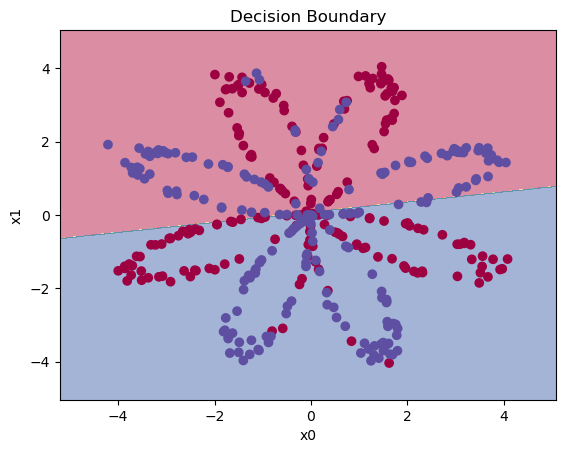

In [11]:
# Train your model
learned_parameters = model(X, y, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(learned_parameters, X, y)


As you should see logistic regression doesn't do a good job in predicting the labels for this dataset. This is because the dataset is not linearly separable, and therefore a simple logistic regression performs poorly on this data. 

**Complete the code cell below with a formula for the accuracy of the model**. This should be the precentage of points for which the model gives the correct classification. **Then run the cell.**

In [12]:
# Print accuracy

predictions = predict(learned_parameters, X)

accuracy = 100*(predictions == y).sum()/len(y[0])
    
print ('Accuracy of logistic regression: %d ' % accuracy +
       '% ' + "(percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)
